In [1]:
# hide
# all_slow

In [2]:
# hide
# no_test
![ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

# DHS Wealth Index
> Basic Introduction to in processing dhs data

In [3]:
%reload_ext autoreload
%autoreload 2

## Loading DHS Data
Note: This data is mocked data

In [4]:
import geopandas as gpd
import pandas as pd

from geowrangler import dhs

In [5]:
dhs_household_data_path = "../data/ph.DTA"
dhs_gps_coorindates = "../data/ph_gps.shp"

In [6]:
dhs_df = dhs.load_dhs_file(dhs_household_data_path)

In [7]:
dhs_df.head()

,,country code and phase,cluster number,source of drinking water,type of toilet facility,has electricity,has radio,has television,has refrigerator,has motorcycle/scooter,has car/truck,main floor material,number of rooms used for sleeping,has mobile telephone,wealth index factor score combined (5 decimals)
0,0,PH7,725,80,61,0,1,0,1,1,1,74,20,0,-168581
1,1,PH7,1009,19,92,1,1,1,1,1,0,51,15,1,127550
2,2,PH7,1072,91,58,1,1,0,1,1,1,26,5,0,32616
3,3,PH7,242,39,93,0,1,0,0,0,1,76,11,0,80338
4,4,PH7,102,11,27,0,0,1,1,1,0,56,15,0,-178758


## Renaming columns to match
DHS files do not have uniform column names. To make analysis easier, we rename commonnly ones. Feel free to extend the config to your usecase.

In [8]:
ph_config = dhs.load_column_config("ph")
ph_config

{'cluster number': 'DHSCLUST',
 'wealth index factor score combined (5 decimals)': 'Wealth Index',
 'country code and phase': 'country code and phase',
 'number of rooms used for sleeping': 'rooms',
 'has electricity': 'electric',
 'has mobile telephone': 'mobile telephone',
 'has radio': 'radio',
 'has television': 'television',
 'has car/truck': 'car/truck',
 'has refrigerator': 'refrigerator',
 'has motorcycle/scooter': 'motorcycle',
 'main floor material': 'floor',
 'type of toilet facility': 'toilet',
 'source of drinking water': 'drinking water'}

In [9]:
renamed_dhs_df = dhs_df.rename(columns=ph_config)

## Cluster Summaries

In [10]:
wealth_col_name = "Wealth Index"
cluster_col_name = "DHSCLUST"
summarized = (
    renamed_dhs_df[[wealth_col_name, cluster_col_name]].groupby(cluster_col_name).mean()
)
summarized.reset_index(inplace=True)
dhs_shp = gpd.read_file(dhs_gps_coorindates)
survey_geo = pd.merge(summarized, dhs_shp, on="DHSCLUST")
survey_geo

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,LATNUM,LONGNUM,geometry
0,3,-232188.000000,PH20XX003,PH,0,0.609945,0.350830,POINT (0.35083 0.60995)
1,4,228860.000000,PH20XX004,PH,0,0.363843,0.281563,POINT (0.28156 0.36384)
2,5,157620.000000,PH20XX005,PH,0,0.715438,0.145014,POINT (0.14501 0.71544)
3,6,40308.500000,PH20XX006,PH,0,0.758501,0.628373,POINT (0.62837 0.75850)
4,6,40308.500000,PH20XX006,PH,0,0.669415,0.479379,POINT (0.47938 0.66942)
...,...,...,...,...,...,...,...,...
995,1247,90273.333333,PH20XX1247,PH,0,0.214682,0.419448,POINT (0.41945 0.21468)
996,1248,212729.500000,PH20XX1248,PH,0,0.189401,0.152806,POINT (0.15281 0.18940)
997,1248,212729.500000,PH20XX1248,PH,0,0.563460,0.023900,POINT (0.02390 0.56346)
998,1250,101508.500000,PH20XX1250,PH,0,0.166465,0.617584,POINT (0.61758 0.16646)


## Recalculating wealth index for a single country

In [11]:
features = [
    "rooms",
    "electric",
    "mobile telephone",
    "radio",
    "television",
    "car/truck",
    "refrigerator",
    "motorcycle",
    "floor",
    "toilet",
    "drinking water",
]

In [12]:
# apply a threshold
dhs.apply_threshold(renamed_dhs_df, columns=features, config={"rooms": [0, 25]})

,,country code and phase,DHSCLUST,drinking water,toilet,electric,radio,television,refrigerator,motorcycle,car/truck,floor,rooms,mobile telephone,Wealth Index
0,0,PH7,725,80,61,0,1,0,1,1,1,74,20,0,-168581
1,1,PH7,1009,19,92,1,1,1,1,1,0,51,15,1,127550
2,2,PH7,1072,91,58,1,1,0,1,1,1,26,5,0,32616
3,3,PH7,242,39,93,0,1,0,0,0,1,76,11,0,80338
4,4,PH7,102,11,27,0,0,1,1,1,0,56,15,0,-178758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,PH7,834,63,83,0,1,1,1,1,1,28,10,0,241846
996,996,PH7,1170,74,78,1,0,1,1,1,0,34,17,1,106424
997,997,PH7,762,81,14,1,1,0,1,1,0,83,12,1,246898
998,998,PH7,63,40,21,0,1,1,1,1,1,12,2,1,-212590


In [13]:
renamed_dhs_df["Recomputed Wealth Index"] = dhs.assign_wealth_index(
    renamed_dhs_df[features], features
)
renamed_dhs_df.head()

,,country code and phase,DHSCLUST,drinking water,toilet,electric,radio,television,refrigerator,motorcycle,car/truck,floor,rooms,mobile telephone,Wealth Index,Recomputed Wealth Index
0,0,PH7,725,80,61,0,1,0,1,1,1,74,20,0,-168581,-63.515731
1,1,PH7,1009,19,92,1,1,1,1,1,0,51,15,1,127550,8.730482
2,2,PH7,1072,91,58,1,1,0,1,1,1,26,5,0,32616,-60.121255
3,3,PH7,242,39,93,0,1,0,0,0,1,76,11,0,80338,-14.959946
4,4,PH7,102,11,27,0,0,1,1,1,0,56,15,0,-178758,-14.060453


## Recalculating wealth index for multiple countries

In [14]:
dhs_ph_path = "../data/ph.DTA"
dhs_kh_path = "../data/kh.DTA"
dhs_mm_path = "../data/mm.DTA"
dhs_tl_path = "../data/tl.DTA"
ph_config = dhs.load_column_config("ph")
kh_config = dhs.load_column_config("kh")
mm_config = dhs.load_column_config("mm")
tl_config = dhs.load_column_config("tl")
dhs_ph_df = dhs.load_dhs_file(dhs_ph_path).rename(columns=ph_config)
dhs_kh_df = dhs.load_dhs_file(dhs_kh_path).rename(columns=kh_config)
dhs_mm_df = dhs.load_dhs_file(dhs_mm_path).rename(columns=mm_config)
dhs_tl_df = dhs.load_dhs_file(dhs_tl_path).rename(columns=tl_config)

In [15]:
cols = list(ph_config.values()) + ["country code and phase"]
merged_df = pd.concat(
    [
        dhs_ph_df[cols],
        dhs_kh_df[cols],
        dhs_mm_df[cols],
        dhs_tl_df[cols],
    ]
)
merged_df = merged_df.fillna(0)

In [16]:
merged_df["Recomputed Wealth Index"] = dhs.assign_wealth_index(merged_df[features])
merged_df.head()

,DHSCLUST,Wealth Index,country code and phase,rooms,electric,mobile telephone,radio,television,car/truck,refrigerator,motorcycle,floor,toilet,drinking water,country code and phase,Recomputed Wealth Index
0,725,-168581,PH7,20,0,0,1,0,1,1,1,74,61,80.0,PH7,122.888238
1,1009,127550,PH7,15,1,1,1,1,0,1,1,51,92,19.0,PH7,78.430888
2,1072,32616,PH7,5,1,0,1,0,1,1,1,26,58,91.0,PH7,108.113989
3,242,80338,PH7,11,0,0,1,0,1,0,0,76,93,39.0,PH7,105.464687
4,102,-178758,PH7,15,0,0,0,1,0,1,1,56,27,11.0,PH7,45.993876


array([[<AxesSubplot:title={'center':'Recomputed Wealth Index'}>]],
      dtype=object)

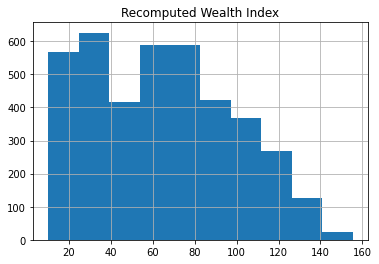

In [17]:
import matplotlib.pyplot as plt  # noqa

merged_df.hist("Recomputed Wealth Index")

In [18]:
merged_df["Recomputed Wealth Index Not PCA"] = dhs.assign_wealth_index(
    merged_df[features], use_pca=False
)
merged_df.head()

,DHSCLUST,Wealth Index,country code and phase,rooms,electric,mobile telephone,radio,television,car/truck,refrigerator,motorcycle,floor,toilet,drinking water,country code and phase,Recomputed Wealth Index,Recomputed Wealth Index Not PCA
0,725,-168581,PH7,20,0,0,1,0,1,1,1,74,61,80.0,PH7,122.888238,-11205.900796
1,1009,127550,PH7,15,1,1,1,1,0,1,1,51,92,19.0,PH7,78.430888,-58091.914108
2,1072,32616,PH7,5,1,0,1,0,1,1,1,26,58,91.0,PH7,108.113989,29489.921730
3,242,80338,PH7,11,0,0,1,0,1,0,0,76,93,39.0,PH7,105.464687,-49902.155270
4,102,-178758,PH7,15,0,0,0,1,0,1,1,56,27,11.0,PH7,45.993876,-39922.425844


array([[<AxesSubplot:title={'center':'Recomputed Wealth Index Not PCA'}>]],
      dtype=object)

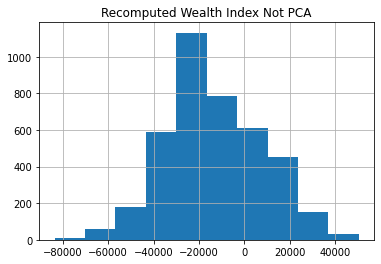

In [19]:
merged_df.hist("Recomputed Wealth Index Not PCA")